In [4]:
import imageio
import random
import numpy as np
import matplotlib.pyplot as plt

from libs.util import readImg, psnr
from libs.Demosaic import rgb2cfa, demosaic

In [5]:
# Init
## Convert RGB Image to Demosaicked Image

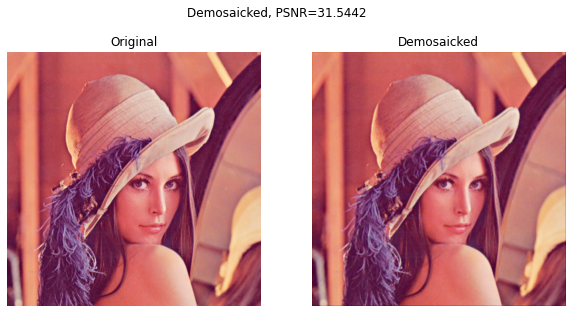

In [8]:
Image = readImg("../_Dataset/Basic/Lena.tiff")
H, W = Image.shape[:2]
cfa = rgb2cfa(Image, pattern='RGGB')
demosaicked_image = demosaic(cfa, pattern='RGGB')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Demosaicked, PSNR={:.4f}".format(psnr(Image, demosaicked_image.astype('uint8'))))
axs[0].imshow(Image)
axs[0].set_title("Original")
axs[0].axis('off')
axs[1].imshow(demosaicked_image)
axs[1].set_title("Demosaicked")
axs[1].axis('off')
plt.show()

## 1. Authentication Codes Generate
Given a demosaicked image DI of W x H pixels, we need to generate W x H x 3 authentication codes of t bits, 
Where t is the length of the authentication code for each color spectrum and can be adaptively selected 
according to the user requirement. 
輸入一張大小為W x H的Demosaicked圖片 DI，我們需要產生W x H x 3大小的t位元驗證碼
t是長度為每個色彩類別的驗證碼，可以根據使用者需求適應的做選擇

- To generate the authentication codes, the pseudo random number generator with a pre-selected seed generates the
W x H x 3 random values.
> 生成驗證碼中PRNG基於預選的種子產生W x H x 3的隨機值
- Each random value rv is converted to t-bit authentication code ac by using the following equation:
$ ac = rv mod 2^t $
> 每個隨機值rv轉換為t位元驗證碼ac，使用下列方程式:

In [9]:
def generate_ac(H, W, seed, t):
    random.seed(seed)
    ac = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(ac.shape[0]):
        for j in range(ac.shape[1]):
            for k in range(ac.shape[2]):
                ac[i, j, k] = random.randint(0, 2**t-1)
    return ac

## 2. Recovery Codes Generate

In [10]:
## block size = m*m
m = 4

## recovery code bit
n = 2

### 2-1. AMBTC

In [11]:
def AMBTC_encode_block(block):
    Ii = np.average(block)
    Bi = np.array(block > Ii, dtype=np.bool)
    ai = np.around(np.mean((Bi*block)[Bi > 0])).astype(np.uint8)
    bi = np.around(np.mean((~Bi*block)[Bi <= 0])).astype(np.uint8)
    return ai if ai is np.nan else bi, bi, Bi

def AMBTC_decode_block(ai, bi, Bi):
    return ai*Bi + bi*(~Bi)

In [12]:
def AMBTC_encoding_color_image(image):
    enData = []
    for i in range(0, H, m):
        enData_line = []
        for j in range(0, W, m):
            enData_dim = []
            for k in range(0, 3):
                block = image[i:i+m, j:j+m, k]
                enData_dim.append(AMBTC_encode_block(block))
            enData_line.append(enData_dim)
        enData.append(enData_line)
    return enData

def AMBTC_decoding_color_image(enData):
    inputData = np.array(enData)
    deData = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range (0, inputData.shape[0]):
        for j in range (0, inputData.shape[1]):
            for k in range(0, 3):
                deData[i*m:i*m+m, j*m:j*m+m, k] = AMBTC_decode_block(inputData[i, j, k, 0], inputData[i, j, k, 1], inputData[i, j, k, 2])
    return deData

In [13]:
ambtc_encode_data = np.array(AMBTC_encoding_color_image(demosaicked_image))
ambtc_encode_data.shape, ambtc_encode_data

C:\Users\BREND\AppData\Local\Temp\ipykernel_30812\2181769242.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Bi = np.array(block > Ii, dtype=np.bool)
C:\Users\BREND\AppData\Local\Temp\ipykernel_30812\1182060626.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ambtc_encode_data = np.array(AMBTC_encoding_color_image(demosaicked_image))


((128, 128, 3, 3),
 array([[[[224, 224, array([[ True, False, False, False],
                            [ True, False, False, False],
                            [ True, False, False, False],
                            [ True, False, False, False]])],
          [91, 91, array([[False,  True, False,  True],
                          [ True,  True,  True,  True],
                          [False,  True,  True,  True],
                          [ True,  True,  True,  True]])],
          [58, 58, array([[False, False, False, False],
                          [False,  True,  True,  True],
                          [False,  True,  True,  True],
                          [False,  True,  True,  True]])]],
 
         [[226, 226, array([[False,  True,  True,  True],
                            [False, False,  True,  True],
                            [False,  True,  True,  True],
                            [False,  True,  True,  True]])],
          [114, 114, array([[False, False, False,  Tru

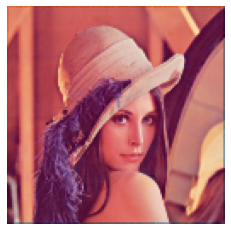

In [14]:
ambtc_decode_image = AMBTC_decoding_color_image(ambtc_encode_data)
plt.imshow(ambtc_decode_image)
plt.axis('off')
plt.show()

### 2-2. convert recovery code into Bit array

In [15]:
def encodeing2nBitBlock_ambtc(arr):
    encoded = np.array(arr)
    block = np.zeros((m, m), dtype=np.uint8)
    block[0, 0:m] = split2nBitArray(encoded[0])
    block[1, 0:m] = split2nBitArray(encoded[1])
    block[2:m, 0:m] = flattenBinaryArray2nBitArray(encoded[2]).reshape(m-2, m)
    return block

def encodeing2nBitBlock(block):
    encoded = np.array(AMBTC_encode_block(block))
    block = np.zeros((m, m), dtype=np.uint8)
    block[0, 0:m] = split2nBitArray(encoded[0])
    block[1, 0:m] = split2nBitArray(encoded[1])
    block[2:m, 0:m] = flattenBinaryArray2nBitArray(encoded[2]).reshape(m-2, m)
    return block

def split2nBitArray(num, bit_size=8):
    num_array = np.zeros(bit_size//n, dtype=np.uint8)
    for i in range(bit_size//n):
        # num_array[-i]=(num % 2**n)
        num_array[bit_size//n-i-1]=(num % 2**n)
        num = num >> n
    return num_array

def flattenBinaryArray2nBitArray(arr):
    fArr = arr.flatten()
    num_array = np.zeros(len(fArr)//n, dtype=np.uint8)
    for i in range (len(fArr)):
        num_array[i//n] = num_array[i//n]*2 + fArr[i]
    return num_array

def encode2nBitBlocks_color_image(image):
    blocks = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(0, H, m):
        for j in range(0, W, m):
            for k in range(0, 3):
                blocks[i:i+m, j:j+m, k] = encodeing2nBitBlock(image[i:i+m, j:j+m, k])
    return blocks

In [16]:
def split2nBitArray(num, bit_size=8, nbit=2):
    num_array = np.zeros(bit_size//nbit, dtype=np.uint8)
    for i in range(bit_size//nbit):
        num_array[bit_size//nbit-i-1]=(num % 2**nbit)
        # num_array[-i]=(num % 2**nbit)
        num = num >> nbit
    return num_array

## DEBUG
np.binary_repr(20), split2nBitArray(20)

('10100', array([0, 1, 1, 0], dtype=uint8))

In [17]:
test = [222, 222,
        np.array([[False, False,  True,  True],
        [False, False,  True,  True],
        [False, False,  True,  True],
        [False, False,  True,  True]])]

## DEBUG
encodeing2nBitBlock_ambtc(test)

C:\Users\BREND\AppData\Local\Temp\ipykernel_30812\2744041582.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded = np.array(arr)


array([[3, 1, 3, 2],
       [3, 1, 3, 2],
       [0, 3, 0, 3],
       [0, 3, 0, 3]], dtype=uint8)

In [18]:
def flattenBinaryArray2nBitArray(arr, nbit=2):
    fArr = arr.flatten()
    print(fArr)
    num_array = np.zeros(len(fArr)//nbit, dtype=np.uint8)
    for i in range (len(fArr)):
        num_array[i//nbit] = num_array[i//nbit]*2 + fArr[i]
    return num_array

## DEBUG
flattenBinaryArray2nBitArray(np.array([[False, False,  True,  True],
        [False, False,  True,  True],
        [False, False,  True,  True],
        [False, False,  True,  True]]))

[False False  True  True False False  True  True False False  True  True
 False False  True  True]


array([0, 3, 0, 3, 0, 3, 0, 3], dtype=uint8)

In [19]:
recovery_code = encode2nBitBlocks_color_image(demosaicked_image)
recovery_code.shape, recovery_code

C:\Users\BREND\AppData\Local\Temp\ipykernel_30812\2181769242.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Bi = np.array(block > Ii, dtype=np.bool)
C:\Users\BREND\AppData\Local\Temp\ipykernel_30812\2744041582.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded = np.array(AMBTC_encode_block(block))


[ True False False False  True False False False  True False False False
  True False False False]
[False  True False  True  True  True  True  True False  True  True  True
  True  True  True  True]
[False False False False False  True  True  True False  True  True  True
 False  True  True  True]
[False  True  True  True False False  True  True False  True  True  True
 False  True  True  True]
[False False False  True  True  True  True  True  True False  True  True
  True  True  True  True]
[False False False False  True  True  True  True  True  True  True  True
  True  True  True  True]
[ True  True  True False  True  True  True False  True  True  True False
  True  True  True False]
[False  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[False False False False  True  True  True  True  True  True  True  True
  True  True  True  True]
[False False  True False False False  True False  True False False False
  True False False False]
[False  Tr

((512, 512, 3),
 array([[[3, 1, 0],
         [2, 1, 3],
         [0, 2, 2],
         ...,
         [2, 1, 0],
         [3, 3, 1],
         [2, 2, 1]],
 
        [[3, 1, 0],
         [2, 1, 3],
         [0, 2, 2],
         ...,
         [2, 1, 0],
         [3, 3, 1],
         [2, 2, 1]],
 
        [[2, 1, 0],
         [0, 1, 0],
         [2, 3, 1],
         ...,
         [2, 0, 0],
         [3, 3, 3],
         [2, 2, 2]],
 
        ...,
 
        [[0, 0, 0],
         [2, 1, 1],
         [3, 1, 3],
         ...,
         [1, 3, 0],
         [0, 0, 3],
         [1, 2, 2]],
 
        [[3, 0, 1],
         [3, 3, 3],
         [3, 0, 1],
         ...,
         [2, 2, 0],
         [3, 3, 3],
         [2, 2, 2]],
 
        [[3, 0, 1],
         [3, 3, 3],
         [0, 0, 1],
         ...,
         [2, 3, 2],
         [0, 2, 2],
         [0, 2, 1]]], dtype=uint8))

### 2-3 convert Bit array into recovery code

In [20]:
def convert_nBitBlock2EncodedData(block):
    ambtc_encoded_data = [0, 0, np.array((m, m), dtype=np.bool)]

    ambtc_encoded_data[0] = combine_nBitArray2Num(block[0, 0:m])
    ambtc_encoded_data[1] = combine_nBitArray2Num(block[1, 0:m])
    ambtc_encoded_data[2] = combine_nBitArray2BinaryArray(block[2:m, 0:m]).reshape(m, m)
    return ambtc_encoded_data

def combine_nBitArray2Num(arr, bit_size=8):
    num = 0
    for a in arr:
        num = num << (bit_size//len(arr))
        num+=a
    return num

def combine_nBitArray2BinaryArray(arr):
    fArr = arr.flatten()
    num_array = np.zeros(len(fArr)*n, dtype=np.bool)
    for i in range (len(fArr)):
        num_array[-i] = fArr[-(i//n)] % 2 == True
        fArr[-(i//n)] = fArr[-(i//n)] >> n
    return num_array

def decode2nBitBlocks_color_image(image):
    deData = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(0, H, m):
        for j in range(0, W, m):
            for k in range(0, 3):
                enData = convert_nBitBlock2EncodedData(image[i:i+m, j:j+m, k])
                deData[i:i+m, j:j+m, k] = AMBTC_decode_block(enData[0], enData[1], enData[2])
    return deData

In [21]:
def combine_nBitArray2Num(arr, bit_size=8):
    num = 0
    for a in arr:
        num = num << (bit_size//len(arr))
        num+=a
    return num

## DEBUG
combine_nBitArray2Num([0, 1, 1, 0])

20

C:\Users\BREND\AppData\Local\Temp\ipykernel_30812\3086247957.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ambtc_encoded_data = [0, 0, np.array((m, m), dtype=np.bool)]
C:\Users\BREND\AppData\Local\Temp\ipykernel_30812\3086247957.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_array = np.zeros(len(fArr)*n, dtype=np.bool)


Check recombine ambtc_decoding equal ambtc_decode_image True


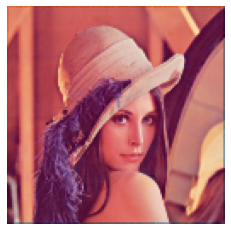

In [22]:
ambtc_decoding = decode2nBitBlocks_color_image(recovery_code)
print("Check recombine ambtc_decoding equal ambtc_decode_image", np.array_equal(ambtc_decoding, ambtc_decode_image))
plt.imshow(ambtc_decoding)
plt.axis('off')
plt.show()